# Reference of SoS actions and functions

## Core Actions

###  Action `run`

`run` is the most frequently used action in sos. In most cases, it is equivalent to action `bash` that uses `bash` to execute specified script. Under the hood, this action is quite different from `bash` because the run action does not have a default interpreter and would behave differently under different situations.

In the simplest case when one or more commands are specified, action `run` would assume it is a batch script under windows, and a bash script otherwise.

In [1]:
run:
    echo "A"

A


However, if the script starts with a shebang line, this action would execute the script directly. This allows you to execute any script in any language. For example, the following script executes a python script using action `run`

In [2]:
run:
    #!/usr/bin/env python
    print('This is python')

This is python


and the following example runs a complete sos script using command `sos-runner`

In [3]:
# use sigil=None to stop interpolating expressions in script
[sos: sigil=None]
run:
    #!/usr/bin/env sos-runner
    [10]
    print("This is ${step_name}")
    [20]
    print("This is ${step_name}")

This is default_10
This is default_20


INFO: Executing default_10: 
INFO: default_10 input:    []
INFO: default_10 output:   []
INFO: Executing default_20: 
INFO: default_20 input:    []
INFO: default_20 output:   []
INFO: Workflow default (ID=fc087fb3ae4c581e) is executed successfully.


Note that action `run`would not analyze shebang line of a script if it is executed in a docker container (with option `docker-image`) and would always assumed to be `bash`.

###  Action `sos_run`

Action `sos_run(workflow=None, targets=None, shared=[], args={}, **kwargs)` executes a specified workflow. The workflow can be a single workflow, a subworkflow (e.g. `A_-10`), a combined workflow (e.g. `A + B`), or a workflow that is constructed to generate `targets`. The workflow

* Takes `_input` of the parental step as the input of the first step of the subworkflow
* Takes `args` (a dictionary) and `**kwargs` as parameters as if they are specified from command line
* Copies variables specified in `shared` (a string or a list of string) to the subworkflow if they exist in the parental namespace
* Returns variables defined in `shared` to the parental namespace after the completion of the workflow

`sos_run` would be executed in a separate process in batch mode, and would be executed in the same process in interactive mode, so parameter `shared` is only needed for batch execution.

The simplest use of action `sos_run` is for the execution of one or more workflows. For example,

In [4]:
[A]
print(step_name)

[B]
print(step_name)

[default]
sos_run('A + B')

A_0
B_0


The subworkflows are executed separately and only takes the `_input` of the step as the `input` of the workflow. For example,

In [5]:
%sandbox
!touch a.txt b.txt

[process]
print("Handling ${input}")

[default]
input: 'a.txt', 'b.txt', group_by=1
sos_run('process')

Handling a.txt
Handling b.txt


If you would like to send one or more variables to the subworkflow or return a variable from the execution of subworkflow, you can specify them with the `shared` variable. The return variable part is a bit tricky here because you can only return workflow level variable that are usually `shared` from a step of the subworkflow. For example,

In [6]:
%sandbox

[process]
print("Working with seed ${seed}")

[default]
for seed in range(5):
    sos_run('process', shared='seed')

Working with seed 0
Working with seed 1
Working with seed 2
Working with seed 3
Working with seed 4


In [7]:
%sandbox

[process: shared='result']
result = 100

[default]
sos_run('process', shared='result')
print("Result from subworkflow process is ${result}")
    

Result from subworkflow process is 100


If the subworkflow accepts parameters, they can be specified using keyword arguments or as a dictionary for parameter `args` of the `sos_run` function. The subworkflow would take values from parameters as if they are passed from command line. 

For example, the following workflow defines parameter `cutoff` with default value 10. When it is executed without command line option, the default value is used.

In [8]:
%sandbox

[default]
parameter: cutoff=10
print("Process with cutoff=${cutoff}")

[batch]
for value in range(2, 10, 2):
    sos_run('default', cutoff=value)

Process with cutoff=10


Command line argument could be used to specify a different `cutoff` value:

In [9]:
%sandbox
%rerun --cutoff=4

Process with cutoff=4


Now, if we run the `batch` workflow, which calls the `default` workflow with parameter `cutoff`, the `parameter: cutoff=10` statement takes the passed value as if it were specified from command line.

In [10]:
%sandbox
%rerun batch

Process with cutoff=2
Process with cutoff=4
Process with cutoff=6
Process with cutoff=8


Note that the parameters could also be specified with parameter `args`, 

In [11]:
%sandbox
%run batch

[default]
parameter: cutoff=10
print("Process with cutoff=${cutoff}")

[batch]
for value in range(2, 10, 2):
    sos_run('default', args={'cutoff': value})

Process with cutoff=2
Process with cutoff=4
Process with cutoff=6
Process with cutoff=8


although the keyword arguments are usually easier to use.

The subworkflow can also be defined by parameter targets, in which case a workflow would be created dynamically to produce the specified targets. Please refer to section [Auxiliary Steps](Auxiliary_Steps.html) for details about such usage.

### Action `report`

Action `report` writes some content to an output stream. The input can either be a string or content of one or more files specified by option `input`. The output is determined by parameter `output`, and command line option `-r`.

* If `output='filename'`, the content will be written to a file.
* If `output=obj` and `obj` has a `write` function (e.g. a file handle), the content will be passed to the `write` function
* If output is unspecified and no filename is specified from option `-r`, the content will be written to standard output.
* If output is unspecified and a filename is specified with option `-r`, the content will be appended to specified file.

For example, the content of `report` actions is printed to standard output if no output is specified.

In [12]:
[10]
report:
    Runing ${step_name}

[20]
report:
    Runing ${step_name}


Runing default_10

Runing default_20



We can specify an output file with option `output`, but the output will be overwritten if multiple actions write to the same file

In [13]:
%sandbox
%preview report.txt
[10]
report: output='report.txt'
    Runing ${step_name}

[20]
report: output='report.txt'
    Runing ${step_name}

%preview report.txt

> report.txt (19 B):

Runing default_20



Option `-r` can be used to set a default output of all `report` actions, in which case the file will be opened in append mode.

In [14]:
%sandbox
%preview report.txt
%run -r report.txt
[10]
report: 
    Runing ${step_name}

[20]
report:
    Runing ${step_name}

%preview report.txt

> report.txt (38 B):

Runing default_10

Runing default_20



An interesting feature of the `-r` option is that the filename passed by this option is treated as double-quoted strings and will be interpolated. This allows the use of a single `-r` option to specify step-dependent output files. For example, 

In [15]:
%sandbox
%preview default_10.txt default_20.txt
%run -r '${step_name}.txt'
[10]
report: 
    Runing ${step_name}

[20]
report:
    Runing ${step_name}

%preview default_10.txt default_20.txt

> default_10.txt (19 B):

Runing default_10



> default_20.txt (19 B):

Runing default_20



Action `report` can also take the content of one or more input files and write them to the output stream, after the script content (if specified). For example, the `report` action in the following example writes the content of `out.txt` to the default report stream (which is the standard output in this case).

In [16]:
%sandbox
[10]
output: 'out.txt'
run:
   # run some command and generate a out.txt
   echo "* some result " > out.txt

[20]
report: input='out.txt'
Summary Report:

Summary Report:

* some result



### Action  `bash`

Action `bash(script)` accepts a shell script and execute it using `bash`. `sh`, `csh`, `tcsh`, `zsh` uses respective shell to execute the provided script.

These actions, as well as all script-executing actions such as `python`, also accept an option `args` and allows you to pass additional arguments to the interpreter. For example

In [17]:
run: args='-n ${filename!q}'
      echo "a"

execute the script with command `bash -n` (check syntax), so command `echo` is not actually executed.

### Action `sh`
Execute script with a `sh` interpreter

### Action  `csh`
Execute script with a `csh` interpreter

### Action  `tcsh`
Execute script with a `tcsh` interpreter

###  Action `zsh`
Execute script with a `zsh` interpreter

### Action  `perl`

Action `perl(script)` execute the passed script using `perl` interpreter.

In [18]:
perl:
    my $name = "Brian";
    print "Hello, $name!\n";

Hello, Brian!


### Action  `ruby`

Action `ruby(script)` execute the passed script using `ruby` interpreter.

In [19]:
ruby:
    a = [ 45, 3, 19, 8 ]
    b = [ 'sam', 'max', 56, 98.9, 3, 10, 'jill' ]
    print (a + b).join(' '), "\n"
    print a[2], " ", b[4], " ", b[-2], "\n"
    print a.sort.join(' '), "\n"
    a << 57 << 9 << 'phil'
    print "A: ", a.join(' '), "\n"

45 3 19 8 sam max 56 98.9 3 10 jill
19 3 10
3 8 19 45
A: 45 3 19 8 57 9 phil


###  Action  `node`

Action `node(script)` executes the passed script using `node` (JavaScript) interpreter.

In [20]:
node:
    var i, a, b, c, max;

    max = 1000000000;

    var d = Date.now();

    for (i = 0; i < max; i++) {
        a = 1234 + 5678 + i;
        b = 1234 * 5678 + i;
        c = 1234 / 2 + i;
    }

    console.log(Date.now() - d);

997


### Action  `pandoc`

Action `pandoc` uses command [pandoc](http://pandoc.org/) to convert specified input to output. This input to this action can be specified from option `script` (usually specified in script format) and `input`.

First, if a script is specified, pandoc assumes it is in markdown format and convert it by default to 'HTML' format. For example,

In [21]:
pandoc:
    # this is header
    This is some test, with **emphasis**.        

<h1 id="this-is-header">this is header</h1>
<p>This is some test, with <strong>emphasis</strong>.</p>


You can specify an output with option `output`

In [22]:
%sandbox
%preview out.html
pandoc: output='out.html'
    Itemize

    * item 1
    * item 2

%preview out.html

> out.html (58 B):

Itemize 

  * item 1 



  * item 2

You can convert input file to another file type using a different file extension

In [23]:
%sandbox
%preview out.tex
pandoc: output='out.tex'
    Itemize

    * item 1
    * item 2

%preview out.tex

> out.tex (80 B):

Itemize

\begin{itemize}
\tightlist
\item


Or you can add more options to the command line by modifying `args`,

In [24]:
%sandbox
%preview out.html
pandoc: output='out.html', args='${input!q} --output ${output!q} -s'
    Itemize

    * item 1
    * item 2

%preview out.html

> out.html (516 B):

code{white-space: pre;} 



Itemize 

  * item 1 



  * item 2

The second usage of the `pandoc` action is to specify one or more input filenames. You have to use the function form of this action as follows

In [25]:
%sandbox
%preview out.html
[10]
report: output = 'out.md'
    Itemize

    * item 1
    * item 2

[20]
pandoc(input='out.md', output='out.html')
    

%preview out.html

> out.html (58 B):

Itemize 

  * item 1 



  * item 2

If multiple files are specified, the content of these input files will be concatenated. This is very useful for generating a single pandoc output with input from different steps. We will demonstrate this feature in the [Generating Reports](../tutorials/Generating_Reports.html) tutorial.

If both `script` and `input` parameters are specified, the content of input files would be appended to `script`. So

In [26]:
#%sandbox
%preview out.html
[10]
report: output = 'out10.md'
    Itemize

    * item 1
    * item 2

[20]
report: output= 'out20.md'
    enumerated

    1. item 1
    2. item 2

[30]
pandoc: input=['out10.md', 'out20.md'], output='out.html'
    Markdown supports both itemized and enumerated

%preview out.html

> out.html (206 B):

Markdown supports both itemized and enumerated 



Itemize 

  * item 1 



  * item 2 







enumerated 

  * item 1 



  * item 2

### Action `docker_build`

Build a docker image from an inline Docker file. The inline version of the action currently does not support adding any file from local machine because the docker file will be saved to a random directory. You can walk around this problem by creating a `Dockerfile` and pass it to the action through option `path`. This action accepts all parameters as specified in [docker-py documentation](http://docker-py.readthedocs.io/en/latest/images.html) because SoS simply pass additional parameters to the `build` function.

For example, the following step builds a docker container for [MISO](http://miso.readthedocs.org/en/fastmiso/) based on anaconda python 2.7.

```
[build_1]
# building miso from a Dockerfile
docker_build: tag='mdabioinfo/miso:latest'

	############################################################
	# Dockerfile to build MISO container images
	# Based on Anaconda python
	############################################################

	# Set the base image to anaconda Python 2.7 (miso does not support python 3)
	FROM continuumio/anaconda

	# File Author / Maintainer
	MAINTAINER Bo Peng <bpeng@mdanderson.org>

	# Update the repository sources list
	RUN apt-get update

	# Install compiler and python stuff, samtools and git
	RUN apt-get install --yes \
	 build-essential \
	 gcc-multilib \
	 gfortran \ 
	 apt-utils \
	 libblas3 \ 
	 liblapack3 \
	 libc6 \
	 cython \ 
	 samtools \
	 libbam-dev \
	 bedtools \
	 wget \
	 zlib1g-dev \ 
	 tar \
	 gzip

	WORKDIR /usr/local
	RUN pip install misopy
```

### Action  `download`

Action `download(URLs, dest_dir='.', dest_file=None, decompress=False)` download files from specified URLs, which can be a list of URLs, or a string with tab, space or newline separated URLs. 

* If `dest_file` is specified, only one URL is allowed and the URL can have any form.
* Otherwise all files will be downloaded to `dest_dir`. Filenames are determined from URLs so the URLs must have the last portion as the filename to save. 
* If `decompress` is True, `.zip` file, compressed or plan `tar` (e.g. `.tar.gz`) files, and `.gz` files will be decompressed to the same directory as the downloaded file.

For example,

```
[10]
GATK_RESOURCE_DIR = '/path/to/resource'
GATK_URL = 'ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/2.8/hg19/'

download:   dest=GATK_RESOURCE_DIR
    ${GATK_URL}/1000G_omni2.5.hg19.sites.vcf.gz
    ${GATK_URL}/1000G_omni2.5.hg19.sites.vcf.gz.md5
    ${GATK_URL}/1000G_omni2.5.hg19.sites.vcf.idx.gz
    ${GATK_URL}/1000G_omni2.5.hg19.sites.vcf.idx.gz.md5
    ${GATK_URL}/dbsnp_138.hg19.vcf.gz
    ${GATK_URL}/dbsnp_138.hg19.vcf.gz.md5
    ${GATK_URL}/dbsnp_138.hg19.vcf.idx.gz
    ${GATK_URL}/dbsnp_138.hg19.vcf.idx.gz.md5
    ${GATK_URL}/hapmap_3.3.hg19.sites.vcf.gz
    ${GATK_URL}/hapmap_3.3.hg19.sites.vcf.gz.md5
    ${GATK_URL}/hapmap_3.3.hg19.sites.vcf.idx.gz
    ${GATK_URL}/hapmap_3.3.hg19.sites.vcf.idx.gz.md5
```

download the specified files to `GATK_RESOURCE_DIR`. The `.md5` files will be automatically used to validate the content of the associated files. Note that 

SoS automatically save signature of downloaded and decompressed files so the files will not be re-downloaded if the action is called multiple times. You can however still still specifies input and output of the step to use step signature


```
[10]
GATK_RESOURCE_DIR = '/path/to/resource'
GATK_URL = 'ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/2.8/hg19/'
RESOUCE_FILES =  '''1000G_omni2.5.hg19.sites.vcf.gz
    1000G_omni2.5.hg19.sites.vcf.gz.md5
    1000G_omni2.5.hg19.sites.vcf.idx.gz
    1000G_omni2.5.hg19.sites.vcf.idx.gz.md5
    dbsnp_138.hg19.vcf.gz
    dbsnp_138.hg19.vcf.gz.md5
    dbsnp_138.hg19.vcf.idx.gz
    dbsnp_138.hg19.vcf.idx.gz.md5
    hapmap_3.3.hg19.sites.vcf.gz
    hapmap_3.3.hg19.sites.vcf.gz.md5
    hapmap_3.3.hg19.sites.vcf.idx.gz
    hapmap_3.3.hg19.sites.vcf.idx.gz.md5'''.split() 
input: []
output:  [os.path.join(GATK_RESOURCE_DIR, x) for x in GATK_RESOURCE_FILES]
download(['${GATK_URL}/${x}' for x in GATK_RESOURCE_FILES], dest=GATK_RESOURCE_DIR)
```

Note that the `download` action uses up to 5 processes to download files. You can change this number by adjusting system configuration `sos_download_processes`.

###  Action `fail_if`

Action `fail_if(expr, msg='')` raises an exception with `msg` (and terminate the execution of the workflow if the exception is not caught) if `expr` returns True.

###  Action `warn_if`

Action `warn_if(expr, msg)` yields a warning message `msg` if `expr` is evaluate to be true.

In [27]:
%sandbox
!touch a.txt
!echo 'something' > b.txt

[10]
input: '*.txt', group_by=1

stop_if(os.path.getsize(_input[0]) == 0)
print(_input)

['b.txt']


skips `a.txt` because it has size 0.

A side effect of `stop_if` is that it will clear `_output` of the iteration so that the step `output` consists of only files from non-stopped iterations. For example,

In [28]:
%sandbox

[10]
input: for_each={'idx': range(10)}
output: "${idx}.txt"
stop_if(idx % 2 == 0)
run:
    echo "Generating ${_output}"
    touch ${_output}

[20]
print("Output of last step is ${input}")

Generating 1.txt
Generating 3.txt
Generating 5.txt
Generating 7.txt
Generating 9.txt
Output of last step is 1.txt 3.txt 5.txt 7.txt 9.txt


## Functions and objects

###  Function `get_output`

Function `get_output(cmd)` returns the output of command (decoded in `UTF-8`), which is a shortcut for `subprocess.check_output(cmd, shell=True).decode()`.

In [29]:
get_output('which ls')

'/bin/ls\n'

This function also accepts two options `show_command=False`, and `prompt='$ '` that can be useful in case you would like to present the command that produce the output. For example,

In [30]:
print(get_output('which ls', show_command=True))

$ which ls
/bin/ls



### Function  `expand_pattern`

Function `expand_pattern` expands a string to multiple ones using items of variables quoted between `{ }`. For example,

```python
output: expand_pattern('{a}_{b}.txt')
```

is equivalent to

```python
output: ['{x}_{y}.txt' for x,y in zip(a, b)]
```

if `a` and `b` are sequences of the same length. For example,

In [31]:
name = ['Bob', 'John']
salary = [200, 300]
expand_pattern("{name}'s salary is {salary}")

["Bob's salary is 200", "John's salary is 300"]

The sequences should have the same length

In [32]:
%sandbox --expect-error

salary = [200]
expand_pattern("{name}'s salary is {salary}")

Failed to process statement 'expand_pattern("{name}\'s salary is {salary}")': Undefined variable name in pattern {name}'s salary is {salary}


An exception is made for variables of simple non-sequence types, in which case they are repeated in all expanded items

In [33]:
salary = 200
expand_pattern("{name}'s salary is {salary}")

["Bob's salary is 200", "John's salary is 200"]

###  Object `logger`

The SoS logger object is a `logging` object used by SoS to produce various outputs. You can use this object to output error, warning, info, debug, and trace messages to terminal. For example,

In [34]:
%run -v2
[0]
logger.info("I am at ${step_name}")

INFO: Running default_0: 
INFO: I am at default_0


The output of `logger` is controlled by logging level, for example, the above message would not be printed at `-v1` (warning)

In [35]:
%run -v1
[0]
logger.info("I am at ${step_name}")

## Language `Python`

### Action `python`

Action `python(script)` and `python3(script)` accepts a Python script and execute it with python or python3, respectively.

Because SoS can include Python statements directly in a SoS script, it is important to note that embedded Python
statements are interpreted by SoS and the `python` and `python3` actions are execute in separate processes without
access to the SoS environment.

For example, the following SoS step execute some python statements **within** SoS with direct access to SoS variables
such as `input`, and with `result` writing directly to the SoS environment,

```python
[10]
for filename in input:
    with open(filename) as data:
        result = filename + '.res'
        ....
```

while

```python
[10]
input: group_by='single'

python:

with open(${input!r}) as data:
   result = ${input!r} + '.res'
   ...


```

composes a Python script for each input file and calls separate Python interpreters to execute them. Whereas
the Python statement in the first example will always be executed, the statements in `python` will not be executed
in `inspect` mode.

### Action `python2`

Action `python2` is similar to `python` but it tries to use interpreter `python2` (or `python2.7` on some systems) before `python`, which could be python 3. Note that this action does not actually test the version of interpreter so it would use python 3 if this is the only available version.

### Action `python3`

Action `python3` is similar to `python` but it tries to use interpreter `python3` (version 3 of python) before `python`, which could be python 2. Note that this action does not actually test the version of interpreter so it would use python 2 if this is the only available version.

### Target `Py_Module`

This target is usually used in the `depends` statement of a SoS step to specify a required Python module. If a module is not available, SoS will try to execute command `pip install` to install it, which might or might not succeed depending on your system configuration. For example,

In [36]:
depends: Py_Module('tabulate')
from tabulate import tabulate
table = [["Sun",696000,1989100000],["Earth",6371,5973.6],
    ["Moon",1737,73.5],["Mars",3390,641.85]]
print(tabulate(table))

-----  ------  -------------
Sun    696000     1.9891e+09
Earth    6371  5973.6
Moon     1737    73.5
Mars     3390   641.85
-----  ------  -------------


## Language `R`

### Action `R`

Action `R(script)` execute the passed script using `Rscript` command. 

In [37]:
R:
    D <- data.frame(x=c(1,2,3,1), y=c(7,19,2,2))
    # Sort on x
    indexes <- order(D$x)
    D[indexes,]

  x  y
1 1  7
4 1  2
2 2 19
3 3  2


### Action `Rmarkdown`

Action `Rmarkdown` shares the same user interface with action `pandoc`. The only big difference is that it used `R`'s `rmarkdown` package to render R-flavored Markdown language.

For example, the `Rmarkdown` action of the following example collects input files `A_10.md` and `A_20.md` and use `R`'s `rmarkdown` package to convert it to `out.html`.

In [38]:
%sandbox

[A_10]
report: output="A_10.md"
    step_10

[A_20]
report: output="A_20.md"
    Itemize

    * item 1
    * item 2

[A_30]
Rmarkdown(input=['A_10.md', 'A_20.md'], output='out.html')


Output created: out.html


/usr/local/bin/pandoc +RTS -K512m -RTS tmpqk3_lemg.utf8.md --to html --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash --output /private/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmpb23pv4ls/out.html --smart --email-obfuscation none --self-contained --standalone --section-divs --template /Library/Frameworks/R.framework/Versions/3.3/Resources/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable 'theme:bootstrap' --include-in-header /var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T//RtmpRFaQz3/rmarkdown-str1f84618af5a2.html --mathjax --variable 'mathjax-url:https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 


### Target `R_library`

The `R_library` target represents a R library. If the libraries are not available, it will try to install it from [CRAN](https://cran.r-project.org/), [bioconductor](https://www.bioconductor.org/), or [github](https://github.com/). Github package name should be formatted as `repo/pkg`. A typical usage of this target would be

null device 
          1 


Warning message:
package ‘ggplot2’ was built under R version 3.3.2 


%preview test.jpg

input: 
output: test.jpg

> test.jpg (30.3 KiB):

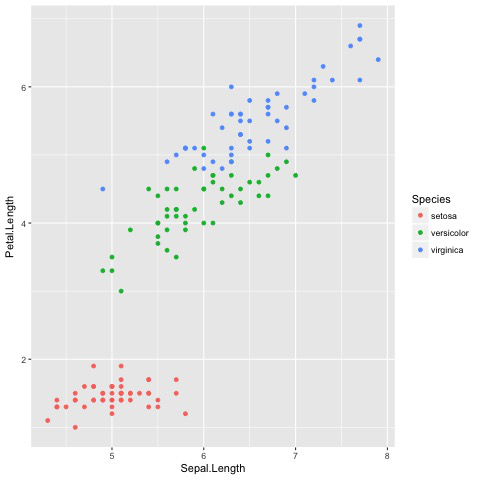

In [39]:
%sandbox
[10]
output: 'test.jpg'
depends: R_library('ggplot2')
R:
  library(ggplot2) 
  jpeg(${output!r})
  qplot(Sepal.Length, Petal.Length, data = iris, color = Species)
  dev.off()


`R_library` can also be used to check for specific versions of packages. For example:

```
R_library('edgeR', '3.12.0')
```
will result in a warning if edgeR version is not 3.12.0. You can specify multiple versions 

```
R_library('edgeR', ['3.12.0', '3.12.1'])
```

certain version or newer,
```
R_library('edgeR', '3.12.0+')
```

certain version or older
```
check_R_library('ggplot2', '1.0.0-')
```

The default R library repo is `http://cran.us.r-project.org`. It is possible to customize the repo for which a R library would be installed, for example:

```
R_library('Rmosek', repos = "http://download.mosek.com/R/7")
```